In [62]:
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline
from imdbpie import Imdb
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [63]:
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests

response = imdb.top_250()

df = pd.DataFrame(response)
df.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1723441,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1177812,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'https://images-na.ssl-images-amazon...,807430,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1709150,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'https://images-na.ssl-images-amazon...,459399,8.9,tt0050083,12 Angry Men,feature,1957


In [64]:
## ABANDONED THIS METHOD OF GETTING INFORMATION AND OPTED FOR OMDBAPI.COM BELOW

### 11 MINUTE EXECUTION
### 11 MINUTE EXECUTION
### 11 MINUTE EXECUTION

#titles = [(x,imdb.get_title_by_id(x)) for x in df['tconst']]

### 11 MINUTE EXECUTION
### 11 MINUTE EXECUTION
### 11 MINUTE EXECUTION

#title_info = [(x[1].genres,x[1].runtime,x[1].certification,x[1].release_date,\
#               x[1].cast_summary) for x in titles]
#title_extra_df = pd.DataFrame(title_info, columns = ['genres','runtime_secs',\
#                                               'certification','release_date', 'cast_summary'])
#title_extra_df.to_csv('title_extra.csv', encoding='utf-8')
#title_extra_df

In [65]:
movies = pd.concat([df],axis=1)
movies.to_csv('movies.csv', encoding='utf-8')
movies.drop(['image','type','type'],axis=1,inplace=True)

In [66]:
####### < 1 Minute Execution Time
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j
entries_dict_list = [get_entry(e) for e in movies['tconst']]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [67]:
movies_extended = pd.DataFrame(entries_dict_list)
movies_extended.drop(['Awards', 'Plot', 'Poster', 'Response', \
                      'Title', 'Type', 'Year','imdbID', 'imdbRating', 'imdbVotes'],axis=1, inplace=True)
movies_extended.head()

movies_extended.to_csv('movies_extended.csv', encoding='utf-8')

In [68]:
movies_extended.head(2)

,Actors,Country,Director,Genre,Language,Metascore,Rated,Released,Runtime,Writer
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",USA,Frank Darabont,"Crime, Drama",English,80,R,14 Oct 1994,142 min,"Stephen King (short story ""Rita Hayworth and S..."
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,R,24 Mar 1972,175 min,"Mario Puzo (screenplay), Francis Ford Coppola ..."


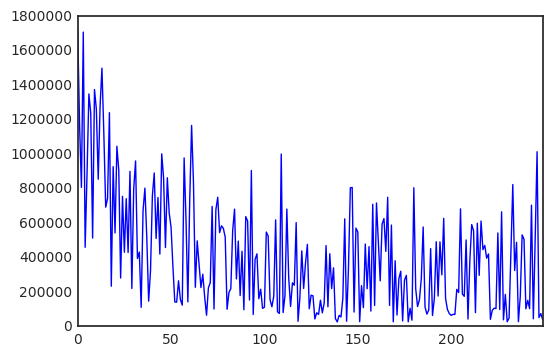

In [69]:
# Lineplot of number of votes in top 250. 
# Number of votes was NOT used in the model. 
movies['num_votes'].plot()

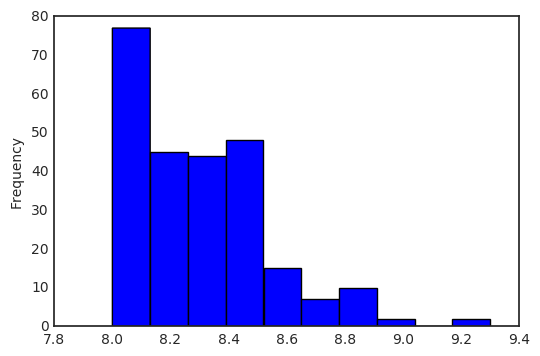

In [70]:
## Histogram of the TOP 250 Ratings
movies['rating'].plot(kind='hist')

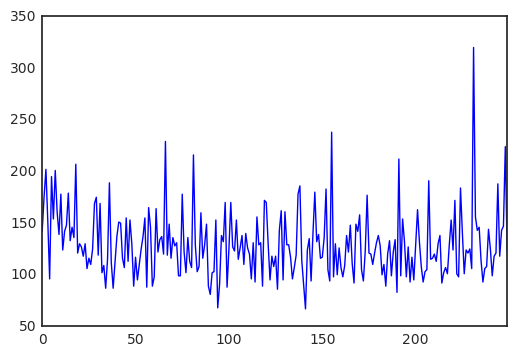

In [71]:
## 
movies['runtime_min'] = movies_extended['Runtime'].apply(lambda x: int(x.split()[0]))
movies['runtime_min'].plot()

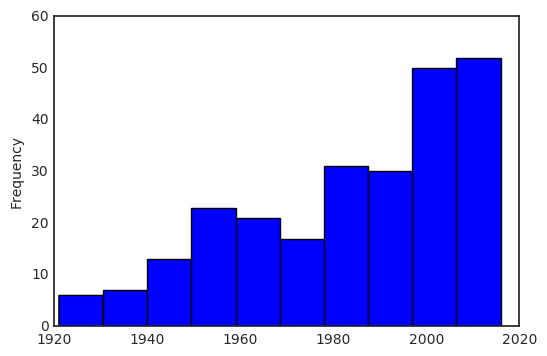

In [72]:
movies['year'].astype(int).plot(kind='hist')

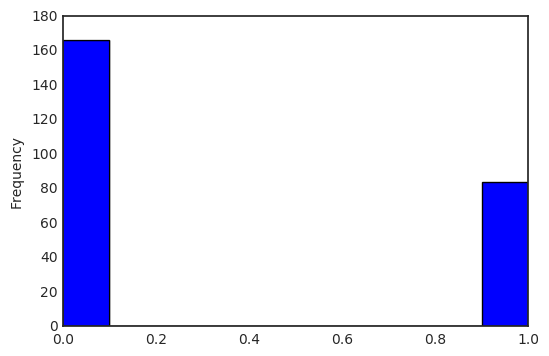

In [73]:
## BINARIZE THE RATINGS 0 <= below median
median_rating = movies['rating'].median()
movies['rating_bin'] = movies['rating'].apply(lambda x: 0 if x <= median_rating else 1)
movies['rating_bin'].plot(kind='hist')

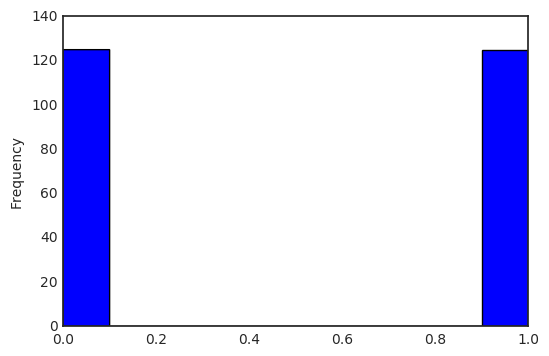

In [74]:
## BINARIZE THE VOTES (NOT USED IN MODEL)
votes_median = movies['num_votes'].median()
movies['votes_bin'] = movies['num_votes'].apply(lambda x: 0 if x <= votes_median else 1)
movies['votes_bin'].plot(kind='hist')

In [75]:
movies_extended.columns

Index([u'Actors', u'Country', u'Director', u'Genre', u'Language', u'Metascore',
       u'Rated', u'Released', u'Runtime', u'Writer'],
      dtype='object')

In [76]:
movies.columns

Index([   u'can_rate',   u'num_votes',      u'rating',      u'tconst',
             u'title',        u'year', u'runtime_min',  u'rating_bin',
         u'votes_bin'],
      dtype='object')

In [77]:
movies = movies.replace('N/A', np.nan)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
can_rate       250 non-null bool
num_votes      250 non-null int64
rating         250 non-null float64
tconst         250 non-null object
title          250 non-null object
year           250 non-null object
runtime_min    250 non-null int64
rating_bin     250 non-null int64
votes_bin      250 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 15.9+ KB


In [78]:
## INT THE YEAR .. NOT USED IN THIS MODEL
movies['year'] = movies['year'].astype(int)

In [79]:
movies_extended.head(2)

,Actors,Country,Director,Genre,Language,Metascore,Rated,Released,Runtime,Writer
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",USA,Frank Darabont,"Crime, Drama",English,80,R,14 Oct 1994,142 min,"Stephen King (short story ""Rita Hayworth and S..."
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,R,24 Mar 1972,175 min,"Mario Puzo (screenplay), Francis Ford Coppola ..."


In [80]:
## WITH CLEEANING, POSSIBILITY FOR FUTURE INCLUSION IN THE MODEL .. NOT USED AT THIS TIME
movies_extended['Rated'].unique()

array([u'R', u'PG-13', u'APPROVED', u'PG', u'UNRATED', u'PASSED', u'G',
       u'NOT RATED', u'M', u'N/A'], dtype=object)

In [81]:
### 50 Greatest Actors & Actresses (100 total stars) .. subjective list provided by UGC (user generated content)
import bs4
from bs4 import BeautifulSoup
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium import webdriver

dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36")
driver = webdriver.PhantomJS(executable_path='/Applications/anaconda/anaconda/bin/phantomJS', desired_capabilities=dcap)
driver.set_window_size(1024, 768) 

## 50 MALE ACTORS
URL = "http://www.imdb.com/list/ls000017393/"
driver.get(URL)
soup_male = BeautifulSoup(driver.page_source, "lxml")

## 50 FEMALE ACTORS
URL = "http://www.imdb.com/list/ls057000570/"
driver.get(URL)
soup_female = BeautifulSoup(driver.page_source, "lxml")

## 25 DIRECTORS
URL = "http://www.imdb.com/list/ls033043539/"
driver.get(URL)
soup_directors = BeautifulSoup(driver.page_source, "lxml")

In [82]:
top_100_actors = []
for i in soup_male.findAll(class_='info'): ## MALE
    top_100_actors.append(i.find('a').text)
    
for i in soup_female.findAll(class_='info'): ##FEMALE
    top_100_actors.append(i.find('a').text)

top_25_directors = []
for i in soup_directors.findAll(class_='info'): ##DIRECTORS
    top_25_directors.append(i.find('a').text)
    
def is_star(name_list,group):
    i=0
    for name_single in name_list.split(','): 
        if name_single.strip() in group:
            i += 1 
    return i
       
movies_extended['star_actor'] = movies_extended['Actors'].apply(lambda x: is_star(x,top_100_actors))     
movies_extended['star_direct'] = movies_extended['Director'].apply(lambda x: is_star(x,top_25_directors))


In [83]:
movies_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
Actors         250 non-null object
Country        250 non-null object
Director       250 non-null object
Genre          250 non-null object
Language       250 non-null object
Metascore      250 non-null object
Rated          250 non-null object
Released       250 non-null object
Runtime        250 non-null object
Writer         250 non-null object
star_actor     250 non-null int64
star_direct    250 non-null int64
dtypes: int64(2), object(10)
memory usage: 23.5+ KB


In [84]:
## CREATE NEW DF FOR countvectorized GENRES
cv = CountVectorizer(tokenizer=lambda x: x.split(', '))
data = cv.fit_transform(movies_extended['Genre']).todense()
columns = ['genre_'+c for c in cv.get_feature_names()]
genredf = pd.DataFrame(data, columns=columns)
print "Genre", genredf.head().shape[1]

## CREATE NEW DF FOR countvectorized ACTORS
cv = CountVectorizer(tokenizer=lambda x: x.split(', '))
data = cv.fit_transform(movies_extended['Actors']).todense()
columns = ['actor: '+c for c in cv.get_feature_names()]
actorsdf = pd.DataFrame(data, columns=columns)
print "Actor", actorsdf.head().shape[1]

## CREATE NEW DF FOR countvectorized COUNTRY
cv = CountVectorizer(tokenizer=lambda x: x.split(', '))
data = cv.fit_transform(movies_extended['Country']).todense()
columns = ['country: '+c for c in cv.get_feature_names()]
countrydf = pd.DataFrame(data, columns=columns)
print "Country", countrydf.head().shape[1]

## CREATE NEW DF FOR countvectorized WRITER
cv = CountVectorizer(tokenizer=lambda x: x.split(', '))
data = cv.fit_transform(movies_extended['Writer']).todense()
columns = ['writer: '+c for c in cv.get_feature_names()]
writerdf = pd.DataFrame(data, columns=columns)
print "Writer", writerdf.head().shape[1]

## CREATE NEW DF FOR countvectorized DIRECTOR
cv = CountVectorizer(tokenizer=lambda x: x.split(', '))
data = cv.fit_transform(movies_extended['Director']).todense()
columns = ['director: '+c for c in cv.get_feature_names()]
directdf = pd.DataFrame(data, columns=columns)
print "Director", directdf.head().shape[1]

Genre 21
Actor 817
Country 36
Writer 629
Director 171


In [85]:
## CREATE THE FINAL DF FOR USE IN MODEL
## THIS MODEL USES :
##   star_actor
##   star_direct
##   genres
movies_final = pd.concat([movies_extended[['star_actor','star_direct']], genredf],axis=1)
movies_final.dtypes

# movies_final = pd.concat([movies_extended[['star_actor','star_direct']], writerdf,genredf, movies[['runtime_min']]],axis=1)
# movies_final.dtypes
# movies_final = pd.concat([movies, directdf, genredf, actorsdf, countrydf, writerdf],axis=1)
# movies_final.dtypes

star_actor         int64
star_direct        int64
genre_action       int64
genre_adventure    int64
genre_animation    int64
genre_biography    int64
genre_comedy       int64
genre_crime        int64
genre_drama        int64
genre_family       int64
genre_fantasy      int64
genre_film-noir    int64
genre_history      int64
genre_horror       int64
genre_music        int64
genre_musical      int64
genre_mystery      int64
genre_romance      int64
genre_sci-fi       int64
genre_sport        int64
genre_thriller     int64
genre_war          int64
genre_western      int64
dtype: object

In [86]:
features = [c for c in movies_final.columns if c not in ['rating_bin', 'rating']]
dfn = movies_final.copy()

## MAKE the X - FEATURES
## MAKE the y - TARGET
X = dfn[features]
y = movies['rating_bin']

In [87]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)
et.fit(X, y)
dt.fit(X, y)

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=21)
s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree CrossValScore", s.mean().round(3), s.std().round(3)))

s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest CrossValScore", s.mean().round(3), s.std().round(3)))

s = cross_val_score(et, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees CrossValScore", s.mean().round(3), s.std().round(3)))

Decision Tree CrossValScore Score:	0.576 ± 0.073
Random Forest CrossValScore Score:	0.577 ± 0.096
Extra Trees CrossValScore Score:	0.553 ± 0.08


,dt_importance,rf_importance,et_importance
star_actor,0.112151,0.170675,0.204955
genre_comedy,0.038674,0.101606,0.064022
genre_thriller,0.086551,0.077339,0.061296
genre_adventure,0.120627,0.063020,0.070666
genre_crime,0.070419,0.060832,0.046400
genre_drama,0.097426,0.059944,0.047502
genre_mystery,0.050671,0.051303,0.047429
star_direct,0.049992,0.050632,0.075399
genre_action,0.052213,0.046352,0.043526
genre_fantasy,0.017143,0.040169,0.033443


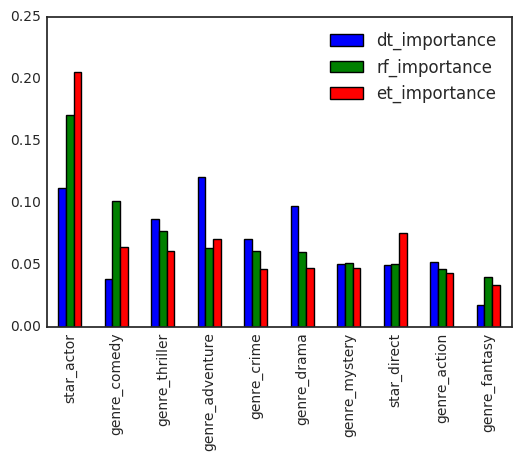

In [88]:
importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)
                   
importances.head(10).plot(kind='bar')
importances.head(10)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


#treeclf = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Evaluating:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Confusion Matrix
-----------------
[[38 12]
 [16  9]]
Classification Report
---------------------
             precision    recall  f1-score   support

          0       0.70      0.76      0.73        50
          1       0.43      0.36      0.39        25

avg / total       0.61      0.63      0.62        75

Accuracy:
---------
0.626666666667
--------------------------------------------------------------------------
Evaluating:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split

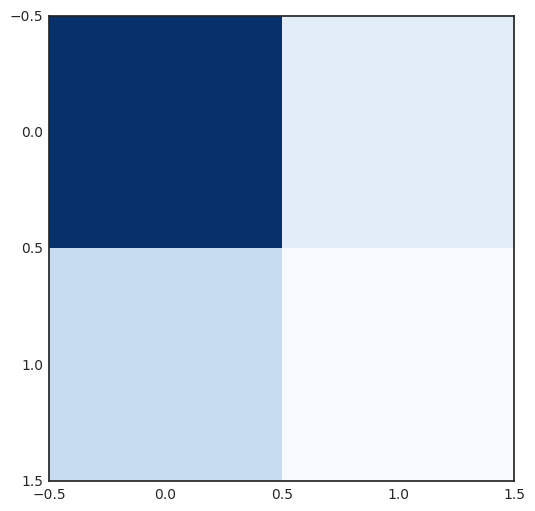

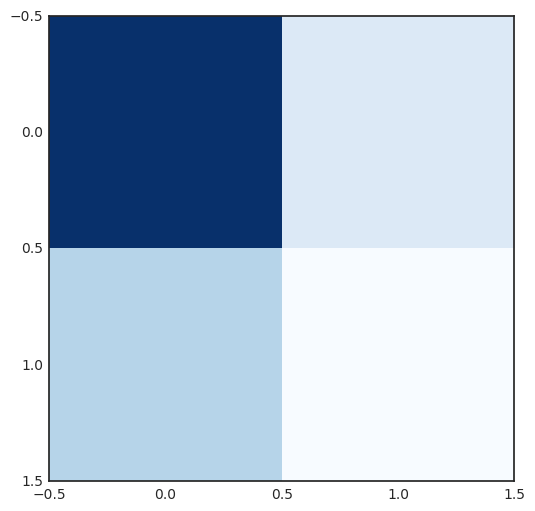

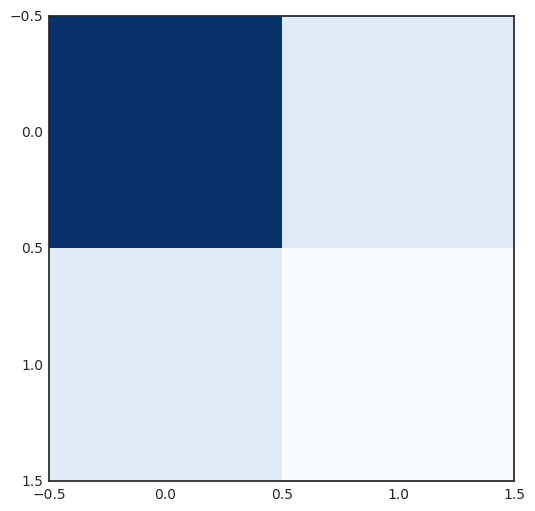

In [90]:
def evaluate_model(model):
    print "Evaluating: ", model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print "Confusion Matrix"
    print "-----------------"
    print cm
    print "Classification Report"
    print "---------------------"
    print cr
    print "Accuracy:"
    print "---------"
    print a
    print "--------------------------------------------------------------------------"
    fig, ax = plt.subplots(figsize=(10,6))
    #print(confusion_matrix(digits.target, y_pred))
    plt.imshow(confusion_matrix(y_test, y_pred),
               cmap='Blues', interpolation='nearest')
    return a

evaluate_model(dt);
evaluate_model(rf);
evaluate_model(et);

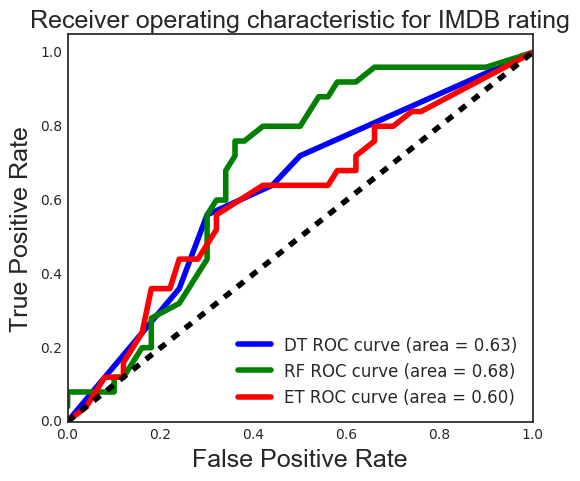

In [92]:
plt.style.use('seaborn-white')
%matplotlib inline

dt_y_score = dt.predict_proba(X_test)[:,1]
rf_y_score = rf.predict_proba(X_test)[:,1]
et_y_score = et.predict_proba(X_test)[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, dt_y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
FPR[2], TPR[2], _ = roc_curve(y_test, rf_y_score)
ROC_AUC[2] = auc(FPR[2], TPR[2])
FPR[3], TPR[3], _ = roc_curve(y_test, et_y_score)
ROC_AUC[3] = auc(FPR[3], TPR[3])

plt.figure(figsize=[6,5])
plt.plot(FPR[1], TPR[1], label='DT ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR[2], TPR[2], label='RF ROC curve (area = %0.2f)' % ROC_AUC[2], linewidth=4)
plt.plot(FPR[3], TPR[3], label='ET ROC curve (area = %0.2f)' % ROC_AUC[3], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB rating', fontsize=18)
plt.legend(loc="lower right")
plt.show()

REFERENCED LECTURES
GA-DSI/DSI_IMAGE/curriculum/week-06/2.2-lab-CARTs/code/solution-code/solution-code-1_2.ipynb
GA-DSI/DSI_IMAGE/curriculum/week-06/2.1-CARTs/w6d2-CARTs-workbook.ipynb
GA-DSI/DSI_IMAGE/curriculum/week-06/5.1-model-eval-feature-importance/w6d5-feature-importance-lecture.ipynb
GA-DSI/DSI_IMAGE/curriculum/week-06/5.2-lab-model-eval-feature-importance/code/solution-code/w6d5-lab-feature-importance-solution-code.ipynb
GA-DSI/DSI_IMAGE/curriculum/week-06/2.4-lab-servers-JSON-APIs/code/solution-code/w6d2-lab-servers-json-apis-solution-code.ipynb
GA-DSI/DSI_IMAGE/curriculum/week-06/5.1-model-eval-feature-importance/w6d5-feature-importance-lecture.ipynb
http://blog.datadive.net/selecting-good-features-part-iii-random-forests/